In [1]:
import os 
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import zip_longest
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
from sklearn.metrics import mean_squared_error 
sys.path.insert(0, '/Users/huripari/Documents/PhD/TCs_Genesis/FS_TCG')
import utils_results as ut

In [2]:
# Set directories
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')
results_dir = os.path.join(fs_dir, 'results')

In [3]:
basin_names = ['Global', 'North East Pacific', 'North West Pacific', 'North Atlantic', 'North Indian', 'South Indian', 'South Pacific']
basins = ['GLB', 'NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']

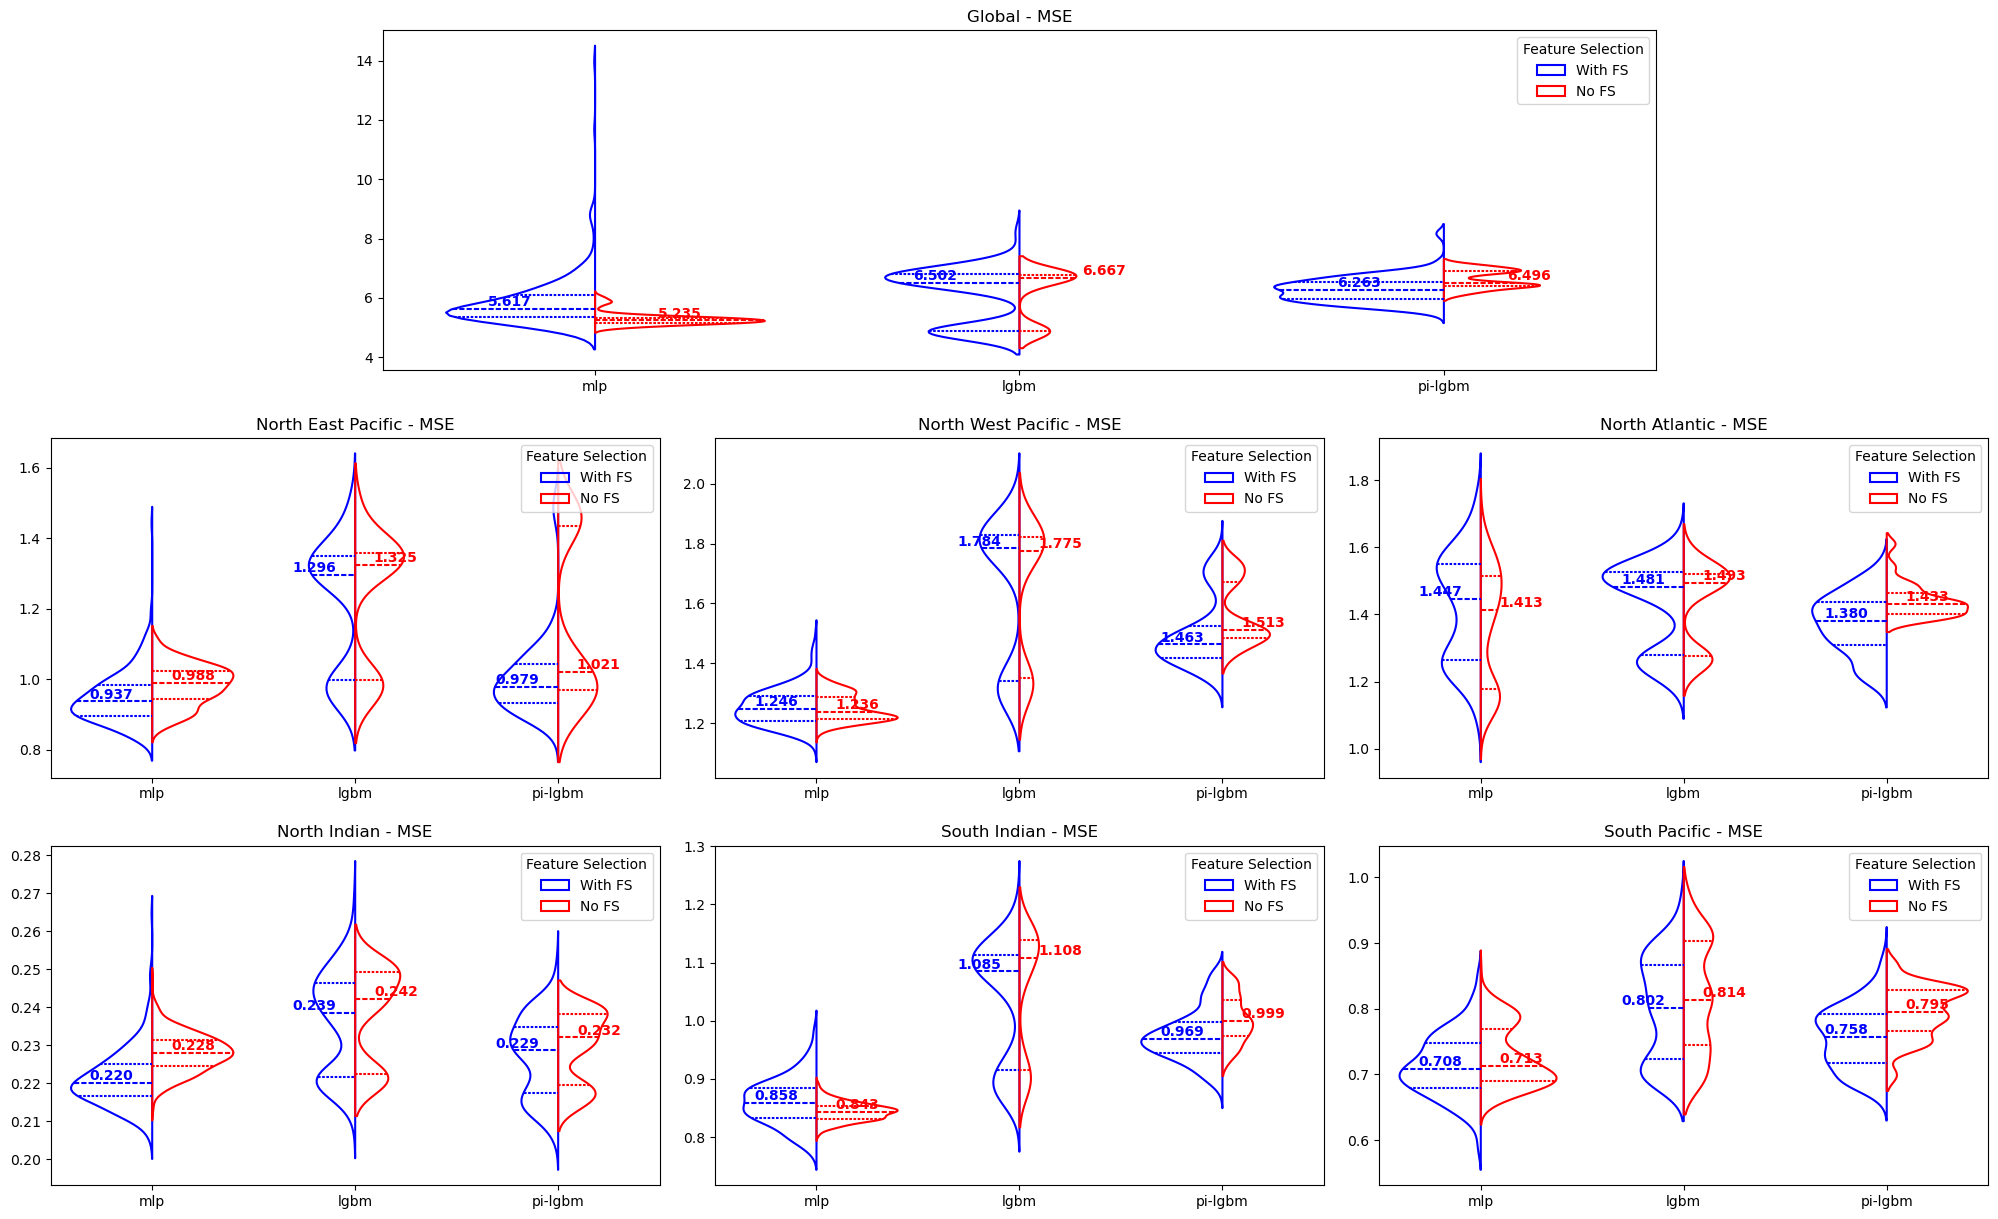

In [4]:
fmod_violin_fig = plt.figure(figsize=(25, 15))
fmod_gs = gridspec.GridSpec(3, 6, figure=fmod_violin_fig)
for bb, basin in enumerate(basins):
    # Load performance tracking file
    track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    track_df = track_df[track_df.index.str.contains('nd9')]
    # Define performance columns and group models of the same type together
    model_pairs = [('mlp', 'mlp_noFS'), ('lgbm', 'lgbm_noFS'), ('pi-lgbm', 'pi-lgbm_noFS')]
    performance_data = []
    model_labels = []
    noFS_labels = []
    median_values = []
    hue_labels = []
    for model, model_noFS in model_pairs:
        sorted_df_model = track_df.sort_values(f'RMSE_{model}', ascending=True)
        sorted_df_model_noFS = track_df.sort_values(f'RMSE_{model_noFS}', ascending=True)
        perf_model = sorted_df_model[f'RMSE_{model}'].values ** 2 # Convert RMSE to MSE
        perf_noFS = sorted_df_model_noFS[f'RMSE_{model_noFS}'].values ** 2 # Convert RMSE to MSE
        performance_data.extend([perf_model, perf_noFS])
        model_labels.extend([model] * len(perf_model))  # Assign label for the standard model
        noFS_labels.extend(["With FS"] * len(perf_model))  # Label indicating feature selection
        model_labels.extend([model] * len(perf_noFS))  # Assign label for noFS model
        noFS_labels.extend(["No FS"] * len(perf_noFS))  # Label indicating no feature selection
        median_values.append(np.median(perf_model))
        hue_labels.append("With FS")  # Assign correct hue label
        median_values.append(np.median(perf_noFS))
        hue_labels.append("No FS")  # Assign correct hue label
    # Create DataFrame for seaborn
    plot_df = pd.DataFrame({
        "MSE": [value for sublist in performance_data for value in sublist],
        "Model": model_labels,
        "Feature Selection": noFS_labels
    })
    # Define subplot positions
    if basin == 'GLB':
        ax = fmod_violin_fig.add_subplot(fmod_gs[0,1:5])
    elif basin == 'NEP':
        ax = fmod_violin_fig.add_subplot(fmod_gs[1,0:2])
    elif basin == 'NWP':
        ax = fmod_violin_fig.add_subplot(fmod_gs[1,2:4])
    elif basin == 'NA':
        ax = fmod_violin_fig.add_subplot(fmod_gs[1,4:])
    elif basin == 'NI':
        ax = fmod_violin_fig.add_subplot(fmod_gs[2,0:2])
    elif basin == 'SI':
        ax = fmod_violin_fig.add_subplot(fmod_gs[2,2:4])
    elif basin == 'SP':
        ax = fmod_violin_fig.add_subplot(fmod_gs[2,4:])
    # Violin plot 
    violin = sns.violinplot(
        x="Model", y="MSE", hue="Feature Selection",
        data=plot_df, ax=ax, inner="quartile", split=True, fill=False,
        palette={"With FS": "blue", "No FS": "red"}
    )
    x_positions = np.arange(len(model_pairs))
    # Add median values to the plot
    for i, (median, hue_label) in enumerate(zip(median_values, hue_labels)):
        color = "blue" if hue_label == "With FS" else "red"
        x_pos = x_positions[i // 2] + (-0.2 if hue_label == "With FS" else 0.2)  # Offset for split violins
        ax.text(x_pos, median, f'{median:.3f}', ha='center', va='bottom', fontsize=10, color=color, fontweight="bold")
    # Set title
    ax.set_title(f'{basin_names[bb]} - MSE')
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.show()

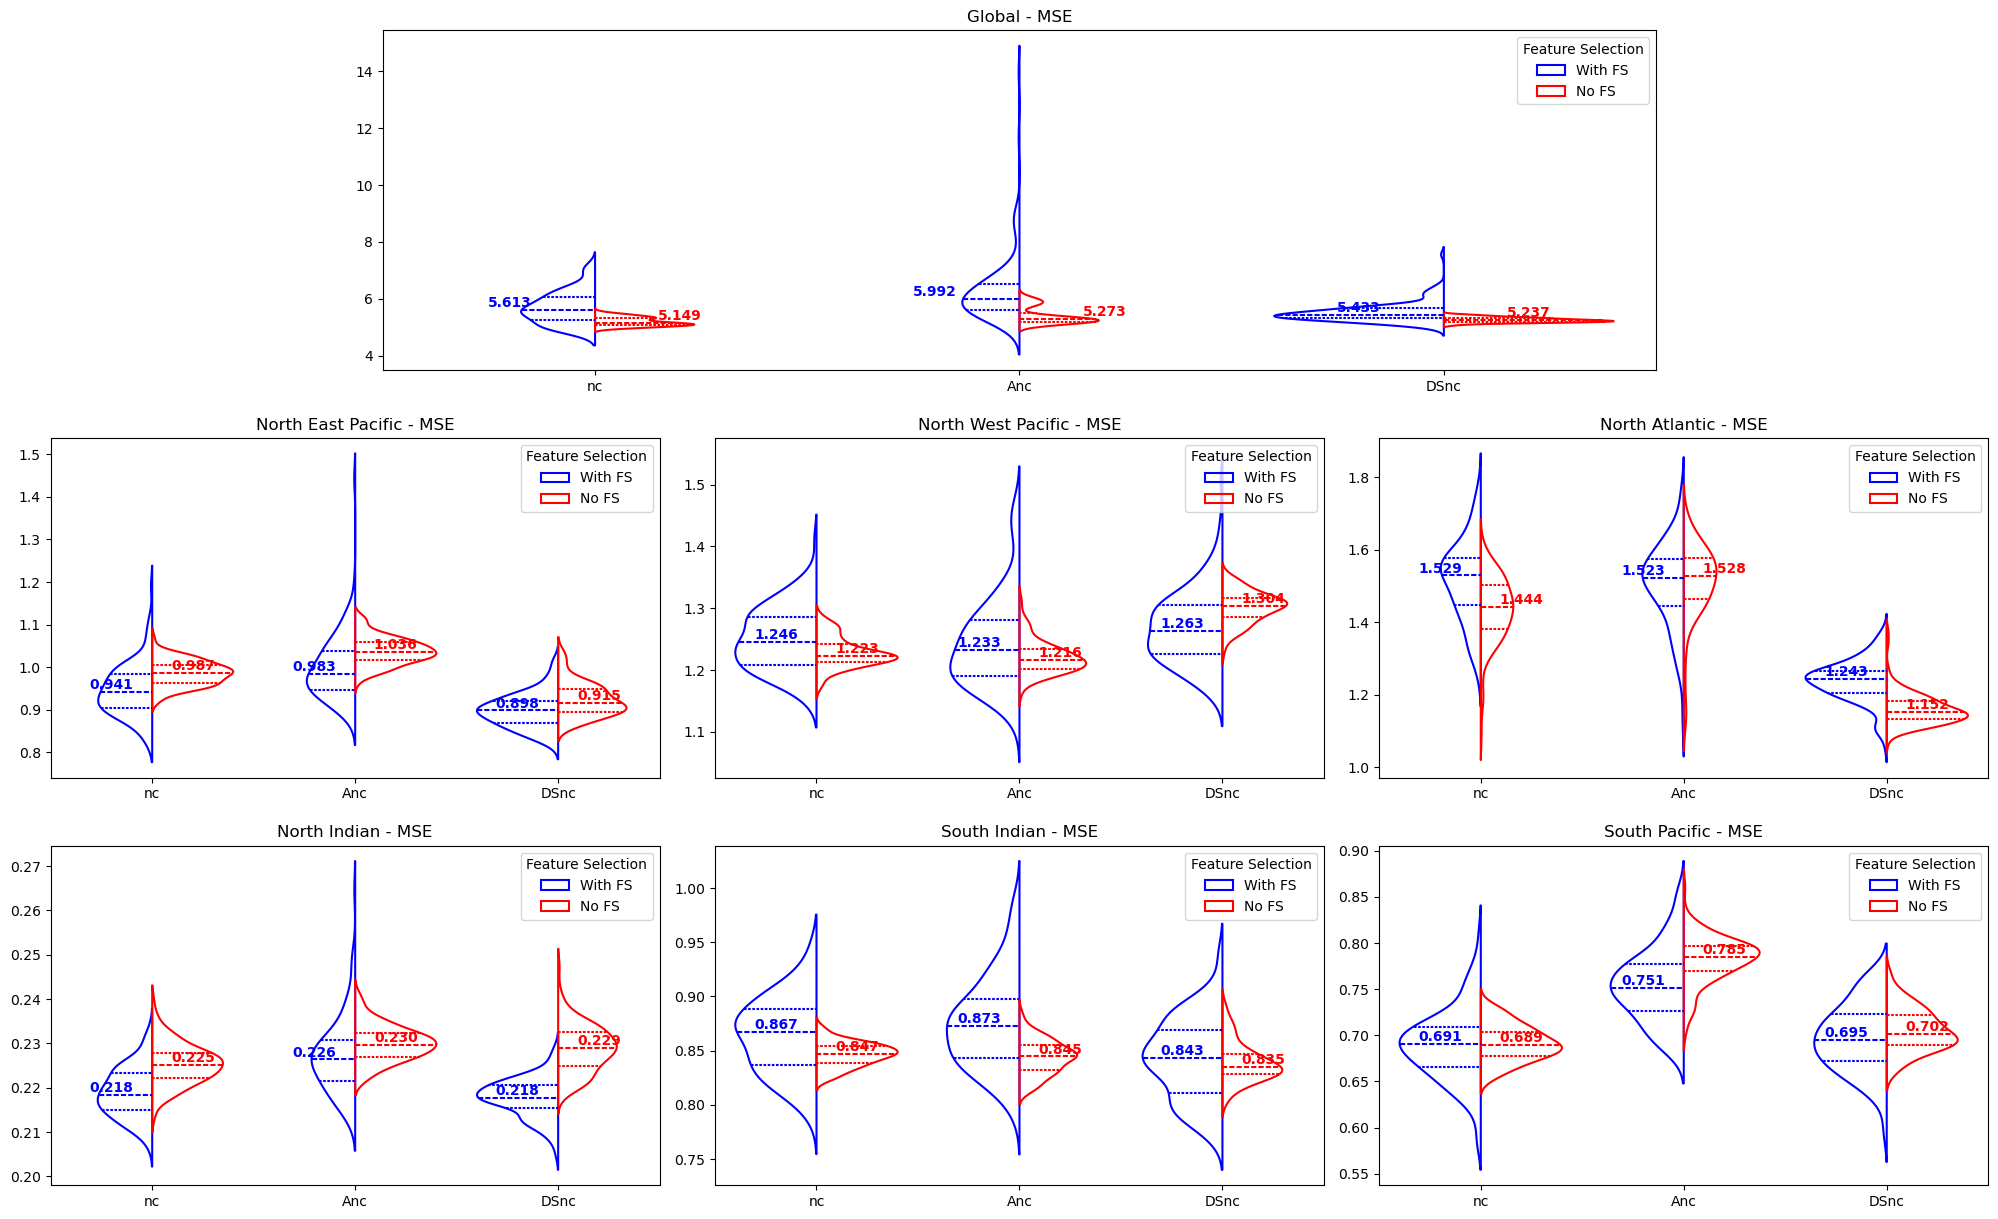

In [5]:
FINAL_MODEL = 'mlp'
cltype_violin_fig = plt.figure(figsize=(25, 15))
cltype_gs = gridspec.GridSpec(3, 6, figure=cltype_violin_fig)
for bb, basin in enumerate(basins):
    # Load file tracking simulation performance
    track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    track_df = track_df[track_df.index.str.contains('nd9')]
    # Define performance metric columns
    performance_col = f'RMSE_{FINAL_MODEL}'
    performance_col_noFS = f'RMSE_{FINAL_MODEL}_noFS'
    # Filter dataframe based on cluster types
    cluster_types = ['_nc', '_Anc', '_DSnc']
    performance_data = []
    cluster_labels = []
    fs_labels = []
    median_values = []
    hue_labels = []
    for cluster_type in cluster_types:
        sorted_df = track_df[track_df.index.str.contains(cluster_type)].sort_values(performance_col, ascending=True)
        sorted_df_noFS = track_df[track_df.index.str.contains(cluster_type)].sort_values(performance_col_noFS, ascending=True)
        # Extract performance data
        perf_model = sorted_df[performance_col].values ** 2 # Convert RMSE to MSE
        perf_noFS = sorted_df_noFS[performance_col_noFS].values ** 2 # Convert RMSE to MSE
        performance_data.extend([perf_model, perf_noFS])
        cluster_labels.extend([cluster_type.replace('_', '')] * len(perf_model))
        fs_labels.extend(["With FS"] * len(perf_model))
        cluster_labels.extend([cluster_type.replace('_', '')] * len(perf_noFS))
        fs_labels.extend(["No FS"] * len(perf_noFS))
        # Store median values for annotation
        median_values.append(np.median(perf_model))
        hue_labels.append("With FS")  # Assign correct hue label
        median_values.append(np.median(perf_noFS))
        hue_labels.append("No FS")  # Assign correct hue label
    # Create DataFrame for seaborn
    plot_df = pd.DataFrame({
        "MSE": [value for sublist in performance_data for value in sublist],
        "Cluster Type": cluster_labels,
        "Feature Selection": fs_labels
    })
    # Define subplot positions
    if basin == 'GLB':
        ax = cltype_violin_fig.add_subplot(cltype_gs[0,1:5])
    elif basin == 'NEP':
        ax = cltype_violin_fig.add_subplot(cltype_gs[1,0:2])
    elif basin == 'NWP':
        ax = cltype_violin_fig.add_subplot(cltype_gs[1,2:4])
    elif basin == 'NA':
        ax = cltype_violin_fig.add_subplot(cltype_gs[1,4:])
    elif basin == 'NI':
        ax = cltype_violin_fig.add_subplot(cltype_gs[2,0:2])
    elif basin == 'SI':
        ax = cltype_violin_fig.add_subplot(cltype_gs[2,2:4])
    elif basin == 'SP':
        ax = cltype_violin_fig.add_subplot(cltype_gs[2,4:])
    # Violin plot with `split=True` to compare FS vs. No FS for each cluster type
    sns.violinplot(
        x="Cluster Type", y="MSE", hue="Feature Selection",
        data=plot_df, ax=ax, inner="quartile", split=True, fill=False,
        palette={"With FS": "blue", "No FS": "red"}
    )
    x_positions = np.arange(len(cluster_types))
    # Add median values to the plot
    for i, (median, hue_label) in enumerate(zip(median_values, hue_labels)):
        color = "blue" if hue_label == "With FS" else "red"
        x_pos = x_positions[i // 2] + (-0.2 if hue_label == "With FS" else 0.2)  # Offset for split violins
        ax.text(x_pos, median, f'{median:.3f}', ha='center', va='bottom', fontsize=10, color=color, fontweight="bold")

    # Set title
    ax.set_title(f'{basin_names[bb]} - MSE')
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.show()

Considering the **median value of mean squared error**:
- _nc: SP
- Anc: NWP
- DSnc: GLB, NEP, NA, NI, SI


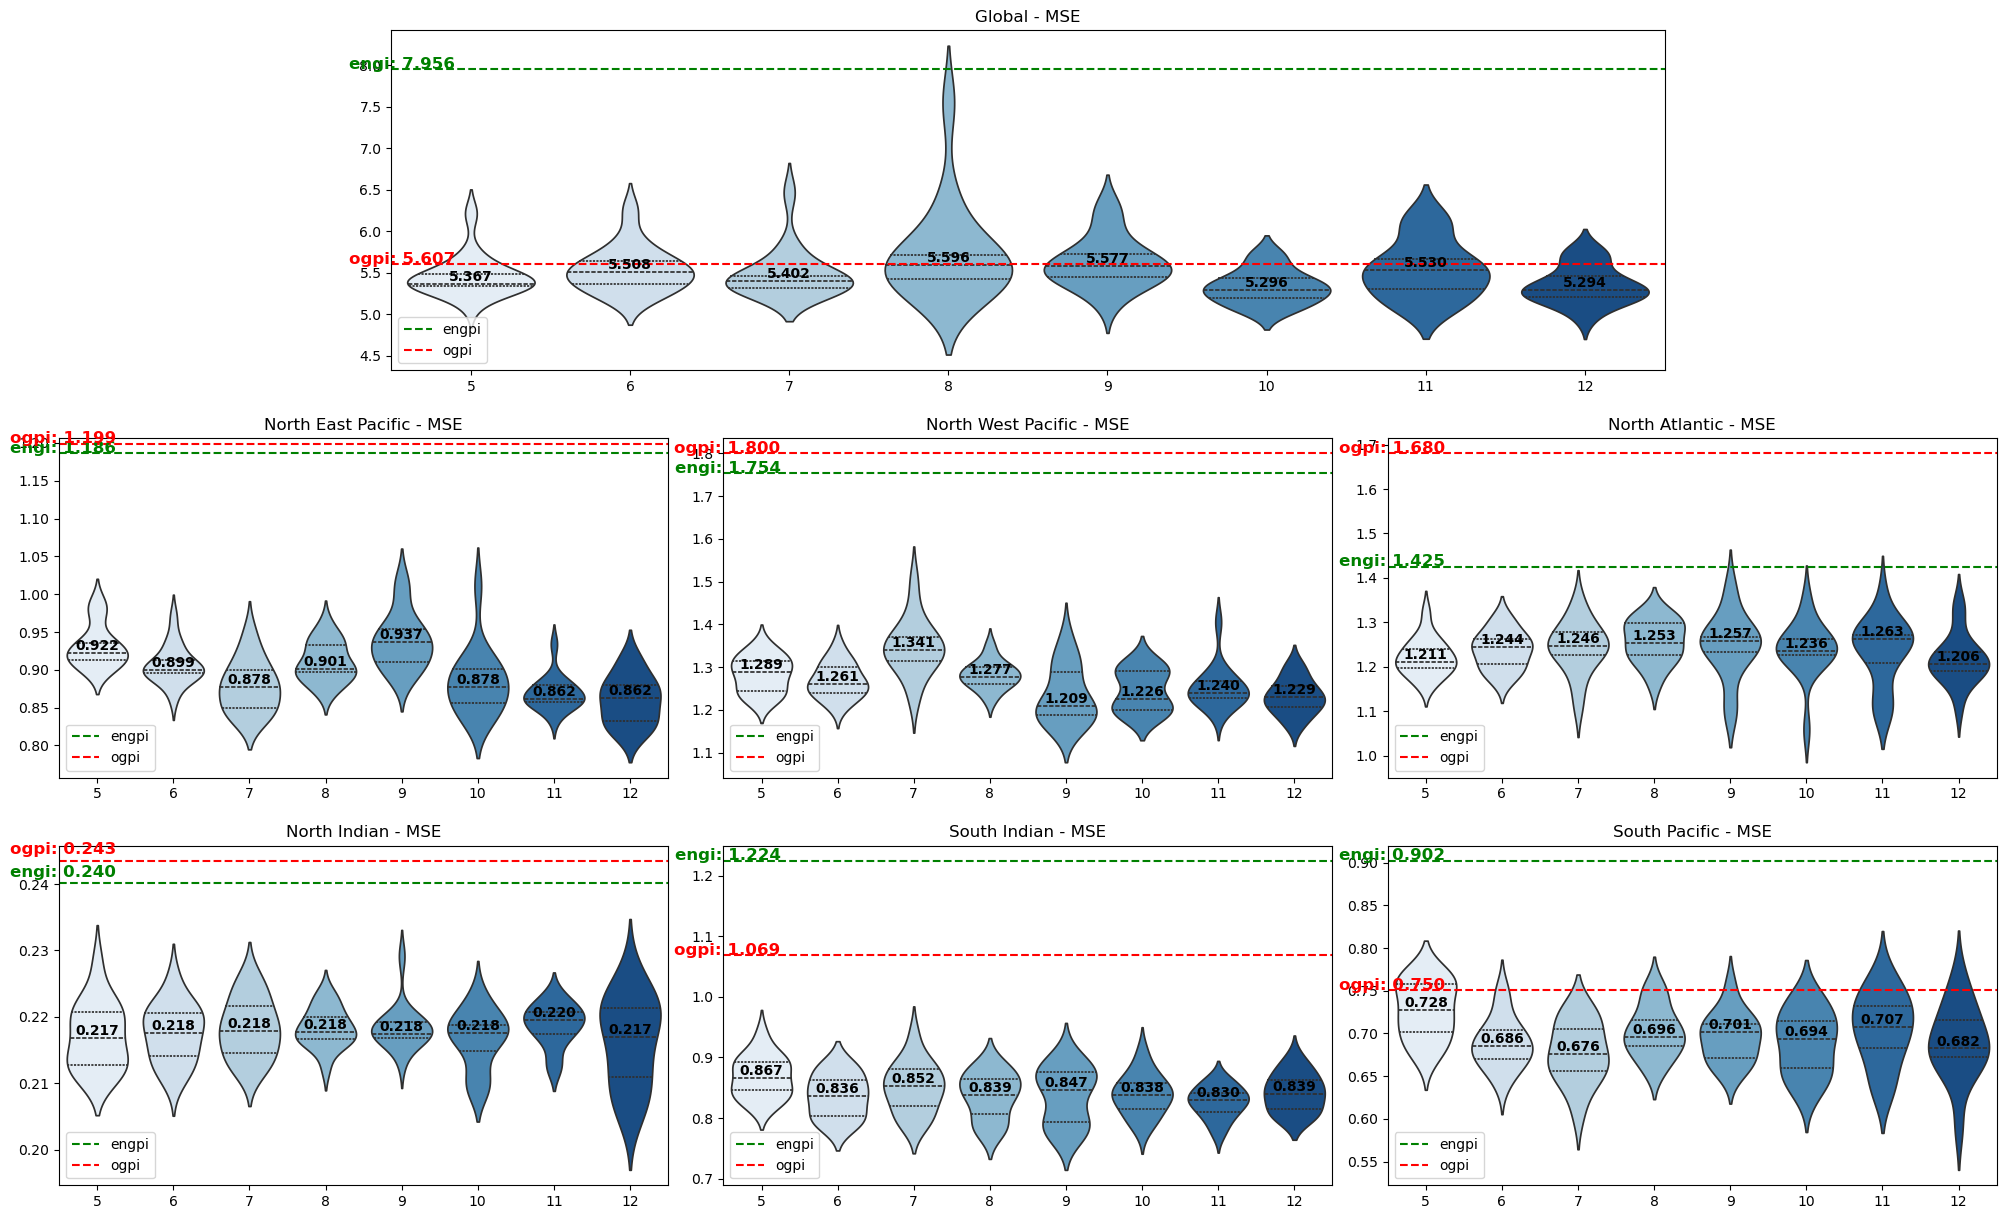

In [6]:
CLUSTER_TYPE = 'DSnc'  # Options: '_nc', '_Anc', '_DSnc'

ncl_violin_fig = plt.figure(figsize=(25, 15))
ncle_gs = gridspec.GridSpec(3, 6, figure=ncl_violin_fig)
for bb, basin in enumerate(basins):
    # Load the file containing the target information
    target_path = os.path.join(fs_dir, 'data', f'{basin}_5clusters', 'target_1970-2022_2.5x2.5.csv')
    target_df = pd.read_csv(target_path, index_col=0)
    target_df.index = pd.to_datetime(target_df.index)
    target_df = target_df.loc['1980':'2021']
    # Load the file containing the information on gpis to compare the mean squared error on the prevision
    gpis_path = os.path.join(fs_dir, 'data', f'{basin}_2.5x2.5_gpis_time_series.csv')
    gpis_df = pd.read_csv(gpis_path, index_col=0)
    gpis_df.index = pd.to_datetime(gpis_df.index)
    gpis_df = gpis_df.loc['1980':'2021']
    # Load file tracking simulation performance
    track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    track_df = track_df[track_df.index.str.contains('nd9')]
    track_df = track_df[track_df.index.str.contains(CLUSTER_TYPE)]
    performance_col = f'RMSE_{FINAL_MODEL}'
    sorted_df = track_df.sort_values(performance_col, ascending=True)
    # Create a list to store data for each cluster count
    cluster_labels = []
    mse_values = []
    median_values = []
    cluster_positions = []
    for ncl in range(5, 13):
        ncl_df = sorted_df[sorted_df['n_clusters'] == ncl]
        mse_vals = ncl_df[performance_col].values ** 2  # Convert RMSE to MSE
        mse_values.extend(mse_vals)
        cluster_labels.extend([str(ncl)] * len(mse_vals))
        # Store median value
        if len(mse_vals) > 0:
            median_values.append(np.median(mse_vals))
            cluster_positions.append(str(ncl))  # Store the cluster position for annotation
    # Create DataFrame for Seaborn
    plot_df = pd.DataFrame({
        "MSE": mse_values,
        "Clusters": cluster_labels
    })
    # Define subplot positions
    if basin == 'GLB':
        ax = ncl_violin_fig.add_subplot(ncle_gs[0,1:5])
    elif basin == 'NEP':
        ax = ncl_violin_fig.add_subplot(ncle_gs[1,0:2])
    elif basin == 'NWP':
        ax = ncl_violin_fig.add_subplot(ncle_gs[1,2:4])
    elif basin == 'NA':
        ax = ncl_violin_fig.add_subplot(ncle_gs[1,4:])
    elif basin == 'NI':
        ax = ncl_violin_fig.add_subplot(ncle_gs[2,0:2])
    elif basin == 'SI':
        ax = ncl_violin_fig.add_subplot(ncle_gs[2,2:4])
    elif basin == 'SP':
        ax = ncl_violin_fig.add_subplot(ncle_gs[2,4:])
    # Create violin plot
    sns.violinplot(x="Clusters", y="MSE", hue="Clusters", data=plot_df, ax=ax, inner="quartile", palette="Blues", legend=False, fill=True)
    # Annotate median values in black
    x_positions = range(len(cluster_positions))
    for x, median in zip(x_positions, median_values):
        ax.text(x, median, f'{median:.3f}', ha='center', va='bottom', fontsize=10, color='black', fontweight="bold")
    # Add horizontal lines to indicate the mean squared error of the gpis
    engpi_mse = mean_squared_error(target_df['tcg'], gpis_df['engpi'])
    ax.axhline(y=engpi_mse, color='green', linestyle='--', label='engpi')
    ogpi_mse = mean_squared_error(target_df['tcg'], gpis_df['ogpi'])
    ax.axhline(y=ogpi_mse, color='red', linestyle='--', label='ogpi')
    x_pospos = -0.1 if basin == 'GLB' else 0.25
    ax.text(x_pospos, engpi_mse+0.001, f'engi: {engpi_mse:.3f}', color='green', fontsize=12, fontweight="bold", ha='right')
    ax.text(x_pospos, ogpi_mse+0.001, f'ogpi: {ogpi_mse:.3f}', color='red', fontsize=12, fontweight="bold", ha='right')
    ax.legend()
    # Set title
    ax.set_title(f'{basin_names[bb]} - MSE')
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.show()


In [60]:
BASIN = 'GLB'
N_CLUSTERS = 12
# Load the performance file for the basin and filter to get the simulation with the best performance
track_file = os.path.join(results_dir, f'sim_performance_{BASIN}.csv')
track_df = pd.read_csv(track_file, index_col=0)
track_df = track_df[track_df.index.str.contains('nd9')]
track_df = track_df[track_df.index.str.contains(CLUSTER_TYPE)]
track_df = track_df[track_df['n_clusters'] == N_CLUSTERS]
# Get the simulation with the best performance
performance_col = f'RMSE_{FINAL_MODEL}'
sorted_df = track_df.sort_values(performance_col, ascending=True)
best_sim = sorted_df.iloc[0]
print(f'Best NN model for {BASIN} with {N_CLUSTERS} clusters: {best_sim.name} - mse: {best_sim[f"RMSE_{FINAL_MODEL}"] ** 2:.3f}')
# Get the best annual correlation for a model with no features selection
sorted_df_noFS = track_df.sort_values(f'RMSE_{FINAL_MODEL}_noFS', ascending=True)
best_sim_noFS = sorted_df_noFS.iloc[0]
print(f'Best NN model for {BASIN} with {N_CLUSTERS} clusters and no FS: {best_sim_noFS.name} - mse: {best_sim_noFS[f"RMSE_{FINAL_MODEL}_noFS"] ** 2:.3f}')

Best NN model for GLB with 12 clusters: test2_linreg_DSnc12_nv8_nd9 - mse: 4.964
Best NN model for GLB with 12 clusters and no FS: test2_lgbm_DSnc12_nv8_nd9 - mse: 5.065


In [61]:
nc_string = best_sim.name.split('_')[2]
if "A" in nc_string:
    cluster_data = f'{BASIN}_{N_CLUSTERS}clusters_anomaly'
elif "DS" in nc_string:
    cluster_data = f'{BASIN}_{N_CLUSTERS}clusters_deseason'
    target_season = 'target_seasonality_1970-2022_2.5x2.5.csv'
else:
    cluster_data = f'{BASIN}_{N_CLUSTERS}clusters'
# Set the paths to files
experiment_filename = f'1970-2022_{N_CLUSTERS}clusters_8vars_9idxs.csv'
predictor_file = 'predictors_' + experiment_filename
data_dir = os.path.join(fs_dir, 'data', cluster_data)
predictors_path = os.path.join(data_dir, predictor_file)
predictors_df = pd.read_csv(predictors_path, index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)
candidate_variables = predictors_df.columns.to_numpy()
target_file = 'target_1970-2022_2.5x2.5.csv'
target_path = os.path.join(data_dir, target_file)
target_df = pd.read_csv(target_path, index_col=0)
target_df.index = pd.to_datetime(target_df.index)


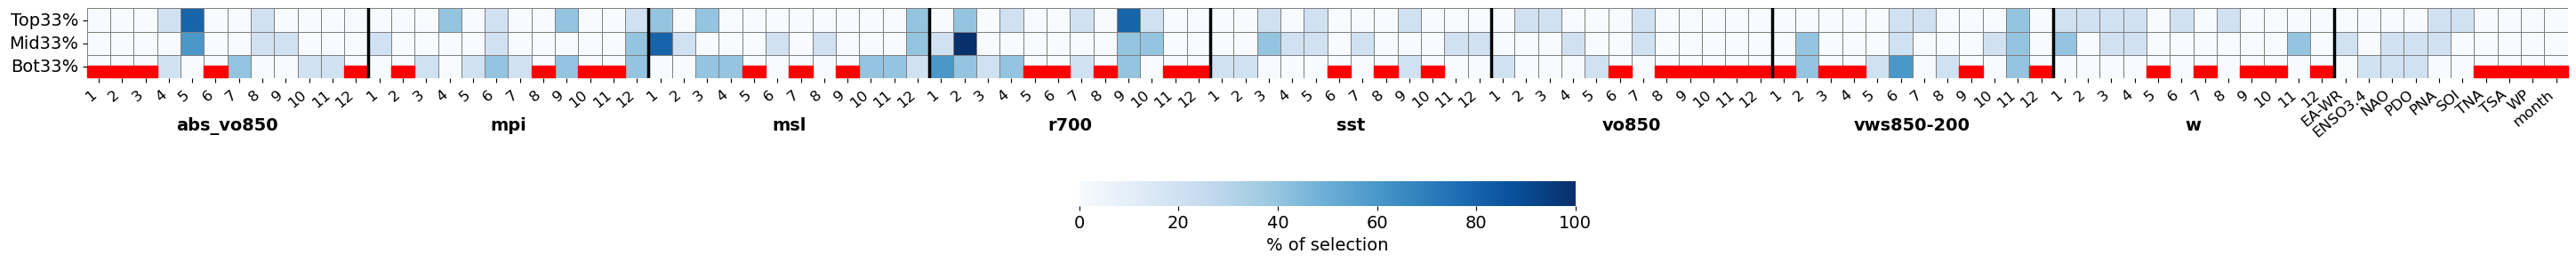

In [62]:
df_tier_sel_perc = pd.DataFrame(0, columns=candidate_variables, index=['Top33%', 'Mid33%', 'Bot33%'])
for r, run_name in enumerate(sorted_df.index):
    model_kind = run_name.split('_')[1]
    sol_filename = f'{model_kind}_{experiment_filename}'
    output_dir = os.path.join(fs_dir, 'results', BASIN, run_name)
    best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
    best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
    best_solution = best_solution.to_numpy().flatten()
    # Select the variables from the best solutions
    column_names = predictors_df.columns.tolist()
    feat_sel = best_solution[2*len(column_names):]
    if r < 5:
        df_tier_sel_perc.loc['Top33%'] = df_tier_sel_perc.loc['Top33%'] + feat_sel
    elif r < 10:
        df_tier_sel_perc.loc['Mid33%'] = df_tier_sel_perc.loc['Mid33%'] + feat_sel
    else:
        df_tier_sel_perc.loc['Bot33%'] = df_tier_sel_perc.loc['Bot33%'] + feat_sel

df_tier_sel_perc = (df_tier_sel_perc / 5) * 100

# Plot the heatmap
plt.figure(figsize=(3*N_CLUSTERS, 10))
ax = sns.heatmap(df_tier_sel_perc, cmap="Blues", linewidths=0.5, linecolor="gray", square=True,
                 cbar_kws={'orientation': 'horizontal', 'label': '% of selection', 'shrink': 0.2, 'aspect': 20})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label('% of selection', fontsize=14)


# Set xticks labels
features_clustered = [var for var in candidate_variables if 'cluster' in var]
features_non_clustered = [var for var in candidate_variables if 'cluster' not in var]
cluster_numbers = [col.split("cluster")[-1] if "cluster" in col else "" for col in features_clustered]
variables = [col.split("_cluster")[0] for col in features_clustered]
variable_positions = [variables.index(var) for var in sorted(set(variables), key=variables.index)]
xticks_labels = cluster_numbers + features_non_clustered
ax.set_xticks(np.arange(len(candidate_variables)) + 0.5)  
ax.set_xticklabels(xticks_labels, rotation=40, ha="right", fontsize=12)
for i, var in enumerate(sorted(set(variables), key=variables.index)):
    xpos = variable_positions[i] + (variable_positions[i+1] - variable_positions[i]) / 2 if i < len(variable_positions) - 1 else variable_positions[i] + N_CLUSTERS/2
    ax.text(xpos, len(df_tier_sel_perc) + 2, var, ha='center', va='center', fontsize=14, fontweight="bold")
# Set the vertical lines between the different variables a bit thicker 
thick_line_pos = [i+1 for i, var in enumerate(candidate_variables) if var.split('_cluster')[-1] == str(N_CLUSTERS)]
for pos in thick_line_pos:
    ax.vlines(x=pos, ymin=-0.5, ymax=len(df_tier_sel_perc), linewidth=2.5, color="black")
# Overlay red blocks at the bottom for zero columns
zero_columns = (df_tier_sel_perc == 0).all(axis=0)
for idx, is_zero in enumerate(zero_columns):
    if is_zero:
        ax.add_patch(plt.Rectangle((idx, len(df_tier_sel_perc) - 0.55), 1, 0.5, color='red', clip_on=False))
# Set yticks labels fontsize
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14);

In [63]:
# Load the performance file for the basin with the additional simulations and filter to get the simulation with the best performance
track_file = os.path.join(results_dir, f'sim_performance_extra_{BASIN}.csv')
track_df = pd.read_csv(track_file, index_col=0)
track_df = track_df[track_df.index.str.contains('nd9')]
track_df = track_df[track_df.index.str.contains(CLUSTER_TYPE)]
track_df = track_df[track_df['n_clusters'] == N_CLUSTERS]
# Get the simulation with the best performance
performance_col = f'RMSE_{FINAL_MODEL}'
sorted_df_extra = track_df.sort_values(performance_col, ascending=True)
best_sim_extra = sorted_df_extra.iloc[0]
print(f'Best NN model for {BASIN} with {N_CLUSTERS} clusters: {best_sim_extra.name} - mse: {best_sim_extra[f"RMSE_{FINAL_MODEL}"] ** 2:.3f}')
# Get the best annual correlation for a model with no features selection
sorted_df_noFS = track_df.sort_values(f'R_Y_{FINAL_MODEL}_noFS', ascending=False)
best_sim_noFS = sorted_df_noFS.iloc[0]
print(f'Best NN model for {BASIN} with {N_CLUSTERS} clusters and no FS: {best_sim_noFS.name} - mse: {best_sim_noFS[f"RMSE_{FINAL_MODEL}_noFS"] ** 2:.3f}')

Best NN model for GLB with 12 clusters: test2_linreg_DSnc12_nv8_nd9 - mse: 4.964
Best NN model for GLB with 12 clusters and no FS: test2_lgbm_DSnc12_nv8_nd9 - mse: 5.065


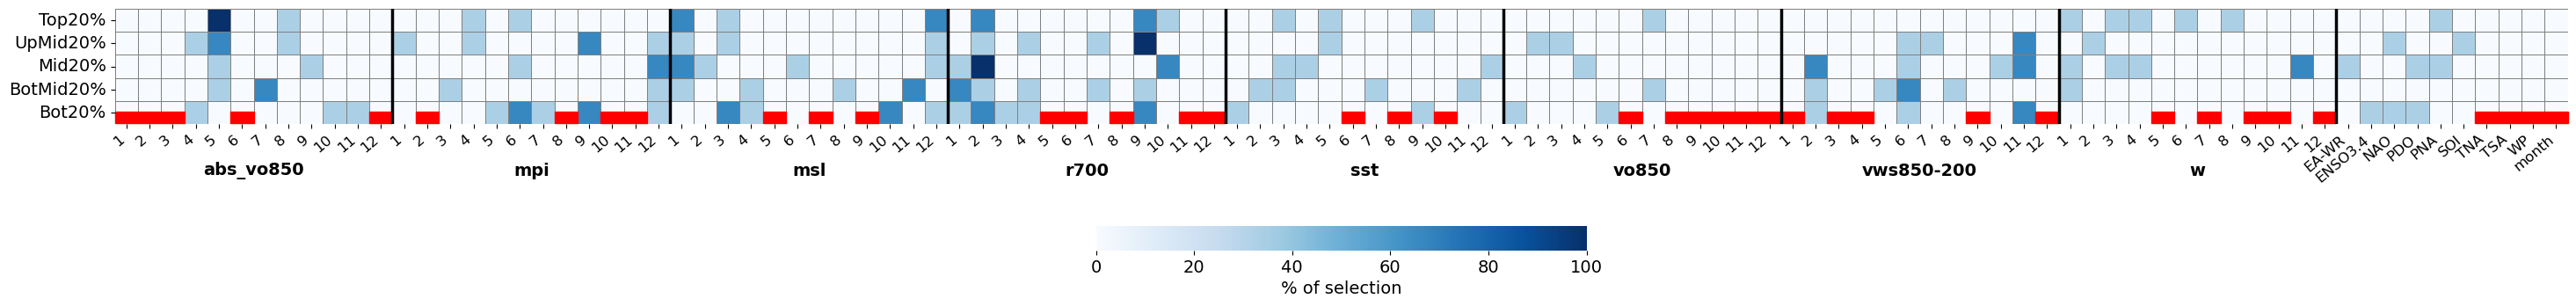

In [64]:
df_tier_sel_perc_extra = pd.DataFrame(0, columns=candidate_variables, index=['Top20%', 'UpMid20%', 'Mid20%', 'BotMid20%', 'Bot20%'])
n_sim = len(sorted_df_extra)
for r, run_name in enumerate(sorted_df_extra.index):
    model_kind = run_name.split('_')[1]
    sol_filename = f'{model_kind}_{experiment_filename}'
    output_dir = os.path.join(fs_dir, 'results', BASIN, run_name)
    best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
    best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
    best_solution = best_solution.to_numpy().flatten()
    # Select the variables from the best solutions
    column_names = predictors_df.columns.tolist()
    feat_sel = best_solution[2*len(column_names):]
    if r < int(n_sim * 0.2):
        df_tier_sel_perc_extra.loc['Top20%'] = df_tier_sel_perc_extra.loc['Top20%'] + feat_sel
    elif r < int(n_sim * 0.4):
        df_tier_sel_perc_extra.loc['UpMid20%'] = df_tier_sel_perc_extra.loc['UpMid20%'] + feat_sel
    elif r < int(n_sim * 0.6):
        df_tier_sel_perc_extra.loc['Mid20%'] = df_tier_sel_perc_extra.loc['Mid20%'] + feat_sel
    elif r < int(n_sim * 0.8):
        df_tier_sel_perc_extra.loc['BotMid20%'] = df_tier_sel_perc_extra.loc['BotMid20%'] + feat_sel
    else:
        df_tier_sel_perc_extra.loc['Bot20%'] = df_tier_sel_perc_extra.loc['Bot20%'] + feat_sel

df_tier_sel_perc_extra = (df_tier_sel_perc_extra / (n_sim * 0.2)) * 100

plt.figure(figsize=(3*N_CLUSTERS, 10))
ax = sns.heatmap(df_tier_sel_perc_extra, cmap="Blues", linewidths=0.5, linecolor="gray", square=True,
                 cbar_kws={'orientation': 'horizontal', 'label': '% of selection', 'shrink': 0.2, 'aspect': 20})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label('% of selection', fontsize=14)

# Set xticks labels
features_clustered = [var for var in candidate_variables if 'cluster' in var]
features_non_clustered = [var for var in candidate_variables if 'cluster' not in var]
cluster_numbers = [col.split("cluster")[-1] if "cluster" in col else "" for col in features_clustered]
variables = [col.split("_cluster")[0] for col in features_clustered]
variable_positions = [variables.index(var) for var in sorted(set(variables), key=variables.index)]
xticks_labels = cluster_numbers + features_non_clustered
ax.set_xticks(np.arange(len(candidate_variables)) + 0.5)  
ax.set_xticklabels(xticks_labels, rotation=40, ha="right", fontsize=12)
for i, var in enumerate(sorted(set(variables), key=variables.index)):
    xpos = variable_positions[i] + (variable_positions[i+1] - variable_positions[i]) / 2 if i < len(variable_positions) - 1 else variable_positions[i] + N_CLUSTERS/2
    ax.text(xpos, len(df_tier_sel_perc_extra) + 2, var, ha='center', va='center', fontsize=14, fontweight="bold")
# Set the vertical lines between the different variables a bit thicker 
thick_line_pos = [i+1 for i, var in enumerate(candidate_variables) if var.split('_cluster')[-1] == str(N_CLUSTERS)]
for pos in thick_line_pos:
    ax.vlines(x=pos, ymin=-0.5, ymax=len(df_tier_sel_perc_extra), linewidth=2.5, color="black")
# Overlay red blocks at the bottom for zero columns
zero_columns = (df_tier_sel_perc_extra == 0).all(axis=0)
for idx, is_zero in enumerate(zero_columns):
    if is_zero:
        ax.add_patch(plt.Rectangle((idx, len(df_tier_sel_perc_extra) - 0.55), 1, 0.5, color='red', clip_on=False))
# Set the yticks labels fontsize
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14);

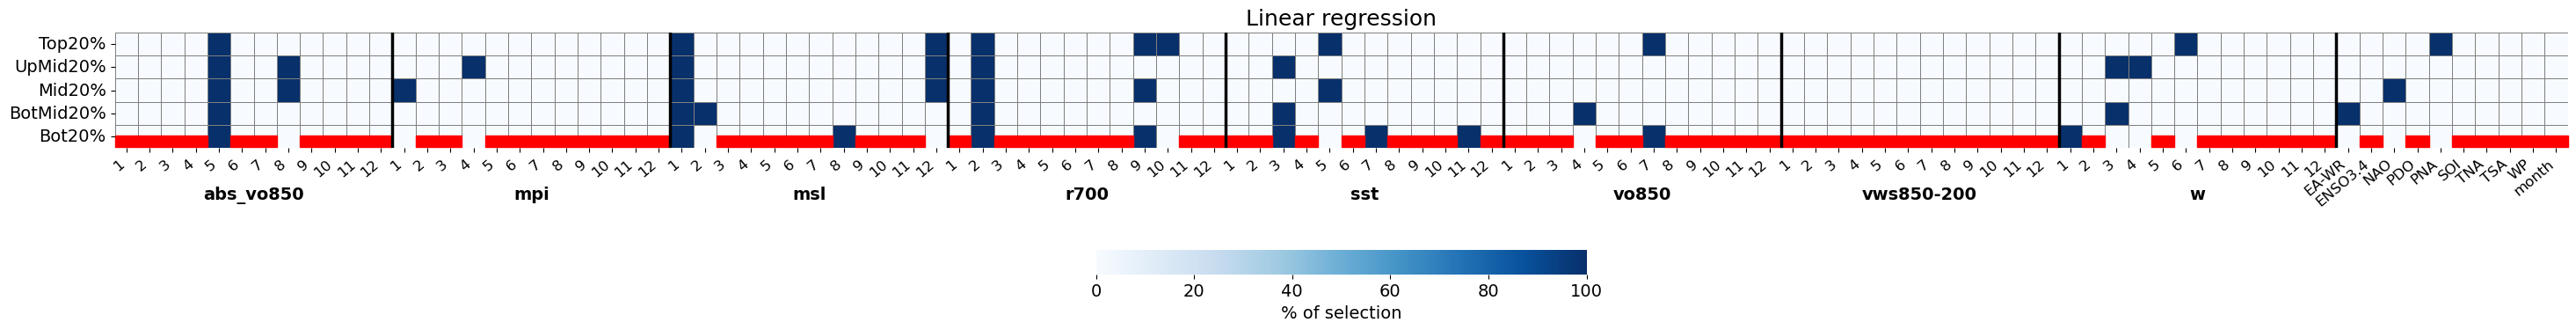

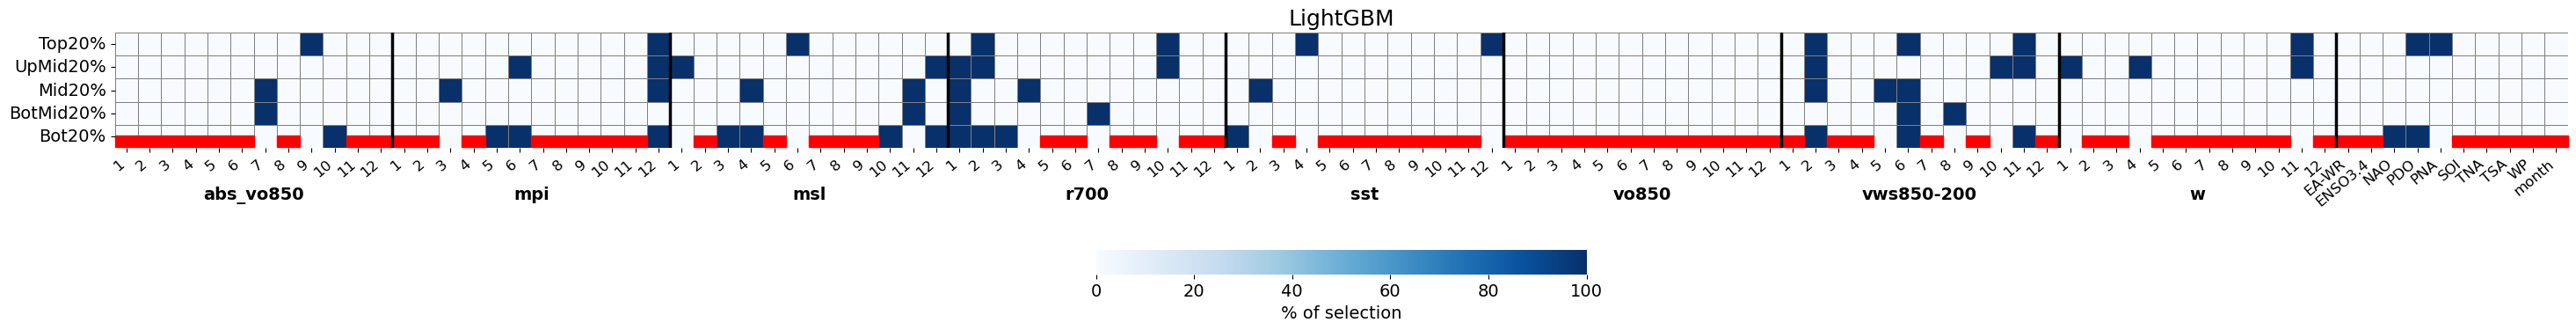

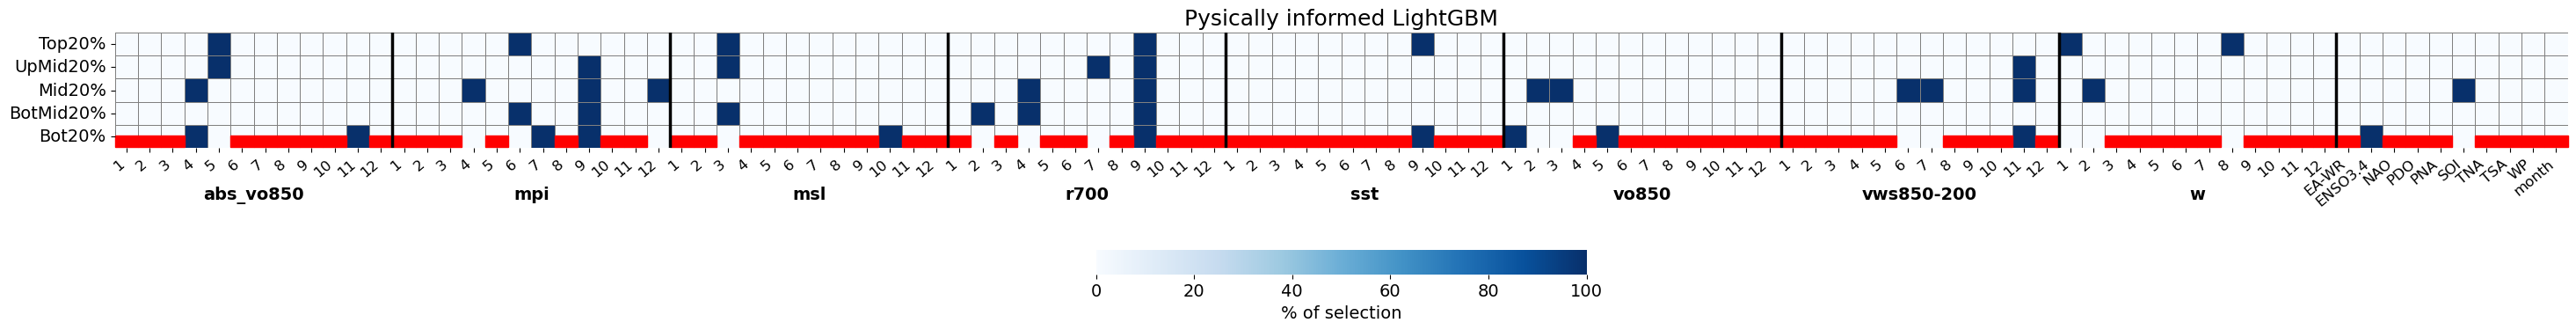

In [65]:
model_kinds = ['linreg', '_lgbm', 'pi-lgbm']
model_names = ['Linear regression', 'LightGBM', 'Pysically informed LightGBM']
for mm, model in enumerate(model_kinds):
    sorted_df_model = sorted_df_extra[sorted_df_extra.index.str.contains(f'{model}')]
    df_tier_sel_perc_model = pd.DataFrame(0, columns=candidate_variables, index=['Top20%', 'UpMid20%', 'Mid20%', 'BotMid20%', 'Bot20%'])
    n_sim = len(sorted_df_model)
    for r, run_name in enumerate(sorted_df_model.index):
        model_kind = run_name.split('_')[1]
        sol_filename = f'{model_kind}_{experiment_filename}'
        output_dir = os.path.join(fs_dir, 'results', BASIN, run_name)
        best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
        best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
        best_solution = best_solution.to_numpy().flatten()
        # Select the variables from the best solutions
        column_names = predictors_df.columns.tolist()
        feat_sel = best_solution[2*len(column_names):]
        if r < int(n_sim * 0.2):
            df_tier_sel_perc_model.loc['Top20%'] = df_tier_sel_perc_model.loc['Top20%'] + feat_sel
        elif r < int(n_sim * 0.4):
            df_tier_sel_perc_model.loc['UpMid20%'] = df_tier_sel_perc_model.loc['UpMid20%'] + feat_sel
        elif r < int(n_sim * 0.6):
            df_tier_sel_perc_model.loc['Mid20%'] = df_tier_sel_perc_model.loc['Mid20%'] + feat_sel
        elif r < int(n_sim * 0.8):
            df_tier_sel_perc_model.loc['BotMid20%'] = df_tier_sel_perc_model.loc['BotMid20%'] + feat_sel
        else:
            df_tier_sel_perc_model.loc['Bot20%'] = df_tier_sel_perc_model.loc['Bot20%'] + feat_sel

    df_tier_sel_perc_model = (df_tier_sel_perc_model / (n_sim * 0.2)) * 100

    plt.figure(figsize=(3*N_CLUSTERS, 10))
    ax = sns.heatmap(df_tier_sel_perc_model, cmap="Blues", linewidths=0.5, linecolor="gray", square=True,
                    cbar_kws={'orientation': 'horizontal', 'label': '% of selection', 'shrink': 0.2, 'aspect': 20})
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('% of selection', fontsize=14)
    ax.set_title(f'{model_names[mm]}', fontdict={'fontsize': 18})

    # Set xticks labels
    features_clustered = [var for var in candidate_variables if 'cluster' in var]
    features_non_clustered = [var for var in candidate_variables if 'cluster' not in var]
    cluster_numbers = [col.split("cluster")[-1] if "cluster" in col else "" for col in features_clustered]
    variables = [col.split("_cluster")[0] for col in features_clustered]
    variable_positions = [variables.index(var) for var in sorted(set(variables), key=variables.index)]
    xticks_labels = cluster_numbers + features_non_clustered
    ax.set_xticks(np.arange(len(candidate_variables)) + 0.5)  
    ax.set_xticklabels(xticks_labels, rotation=40, ha="right", fontsize=12)
    for i, var in enumerate(sorted(set(variables), key=variables.index)):
        xpos = variable_positions[i] + (variable_positions[i+1] - variable_positions[i]) / 2 if i < len(variable_positions) - 1 else variable_positions[i] + N_CLUSTERS/2
        ax.text(xpos, len(df_tier_sel_perc_model) + 2, var, ha='center', va='center', fontsize=14, fontweight="bold")
    # Set the vertical lines between the different variables a bit thicker 
    thick_line_pos = [i+1 for i, var in enumerate(candidate_variables) if var.split('_cluster')[-1] == str(N_CLUSTERS)]
    for pos in thick_line_pos:
        ax.vlines(x=pos, ymin=-0.5, ymax=len(df_tier_sel_perc_model), linewidth=2.5, color="black")
    # Overlay red blocks at the bottom for zero columns
    zero_columns = (df_tier_sel_perc_model == 0).all(axis=0)
    for idx, is_zero in enumerate(zero_columns):
        if is_zero:
            ax.add_patch(plt.Rectangle((idx, len(df_tier_sel_perc_model) - 0.55), 1, 0.5, color='red', clip_on=False))
    # Set the yticks labels fontsize
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14);